## Verify Notebook Configuration and Find Data File

In [1]:
# IF IN COLAB, MOUNT GOOGLE DRIVE
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
#SET DIRECTORY LOCATION FOR NOTEBOOK AND DATA
%cd /content/drive/MyDrive/DLHProject/projecta
%pwd

import os
if not os.path.exists('./data/seer_processed.csv'):
    print('######DATA FILE NOT FOUND IN ./data  #####')
    print('1. Verify you are in the right working directory')
    print('   If not, change the %cd link above in this cell')
    print('2. Verify that that the ./data/seer_processed.csv exists from this directory')
    print('   If not, download data.zip from Gihub and unzip in working directory')
    assert False, "CAN NOT FIND DATA FILE"


[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/DLHProject/projecta'
C:\git\CHS598_fork


# REFERENCES
Reference: Pycox Tutorial 02_Introduction  
https://nbviewer.org/github/havakv/pycox/blob/master/examples/02_introduction.ipynb  
https://github.com/havakv/pycox

Explanation of Model  
https://towardsdatascience.com/how-to-implement-deep-neural-networks-for-time-to-event-analyses-9aa0aeac4717 

Torchtuples - used to format dataset  
https://github.com/havakv/torchtuples 

Bert Model (Hugging Bear)  
https://huggingface.co/transformers/v3.5.1/_modules/transformers/modeling_bert.html  


# Install Dependencies

In [3]:
%%capture
import sys
if 'torch' not in sys.modules:
    !pip install torch===1.5.0 torchvision===0.6.0 -f https://download.pytorch.org/whl/torch_stable.html --user

In [4]:
%%capture
!pip install -r requirements.txt --user

# Load Libraries

In [5]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# For preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
from torch import Tensor, device, dtype, nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import pdb
import math, os
from typing import Any, Callable, Dict, List, Optional, Set, Tuple, Union
import inspect
import warnings
from easydict import EasyDict
from collections import defaultdict
from sksurv.metrics import concordance_index_ipcw, brier_score

## PYCOX SURVIVAL ANALYSIS FUNCTIONS
import torchtuples as tt
from pycox.datasets import metabric, support
from pycox.models import LogisticHazard
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.evaluation import EvalSurv
from pycox.models.loss import NLLPCHazardLoss
from pycox.preprocessing.discretization import (make_cuts, IdxDiscUnknownC, _values_if_series,
    DiscretizeUnknownC, Duration2Idx)


np.random.seed(1234)
_ = torch.manual_seed(123)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
print(f'running on {DEVICE}')

running on cuda


# Data Set Exploration

## SEER

In [7]:
PATH_DATA = "./data/seer_processed.csv"
df = pd.read_csv(PATH_DATA)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476746 entries, 0 to 476745
Data columns (total 21 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   Sex                                                   476746 non-null  int64  
 1   Year of diagnosis                                     476746 non-null  int64  
 2   Race recode (W, B, AI, API)                           476746 non-null  int64  
 3   Histologic Type ICD-O-3                               476746 non-null  int64  
 4   Laterality                                            476746 non-null  int64  
 5   Sequence number                                       476746 non-null  int64  
 6   ER Status Recode Breast Cancer (1990+)                476746 non-null  int64  
 7   PR Status Recode Breast Cancer (1990+)                476746 non-null  int64  
 8   Summary stage 2000 (1998-2017)              

In [8]:
df.head()

,Sex,Year of diagnosis,"Race recode (W, B, AI, API)",Histologic Type ICD-O-3,Laterality,Sequence number,ER Status Recode Breast Cancer (1990+),PR Status Recode Breast Cancer (1990+),Summary stage 2000 (1998-2017),RX Summ--Surg Prim Site (1998+),...,First malignant primary indicator,Diagnostic Confirmation,Median household income inflation adj to 2019,Regional nodes examined (1988+),CS tumor size (2004-2015),Total number of benign/borderline tumors for patient,Total number of in situ/malignant tumors for patient,duration,event_heart,event_breast
0,0,1,3,1,1,1,2,1,2,9,...,0,3,8,-0.484635,-0.338709,-0.079797,0.941035,81,0.0,1.0
1,0,1,3,0,1,1,1,1,2,9,...,0,3,8,-0.484635,-0.193297,-0.079797,0.941035,7,0.0,0.0
2,0,9,3,5,4,2,0,0,1,0,...,0,3,8,4.834512,3.441995,-0.079797,2.454367,28,0.0,1.0
3,0,8,3,0,4,1,2,2,1,4,...,0,3,8,-0.484635,-0.334882,-0.079797,2.454367,75,0.0,0.0
4,0,10,3,0,4,1,2,2,1,13,...,0,3,8,-0.430906,-0.308096,-0.079797,0.941035,57,0.0,0.0


In [9]:
df.describe()

,Sex,Year of diagnosis,"Race recode (W, B, AI, API)",Histologic Type ICD-O-3,Laterality,Sequence number,ER Status Recode Breast Cancer (1990+),PR Status Recode Breast Cancer (1990+),Summary stage 2000 (1998-2017),RX Summ--Surg Prim Site (1998+),...,First malignant primary indicator,Diagnostic Confirmation,Median household income inflation adj to 2019,Regional nodes examined (1988+),CS tumor size (2004-2015),Total number of benign/borderline tumors for patient,Total number of in situ/malignant tumors for patient,duration,event_heart,event_breast
count,476746.000000,476746.000000,476746.000000,476746.000000,476746.000000,476746.000000,476746.000000,476746.000000,476746.000000,476746.000000,...,476746.000000,476746.000000,476746.000000,4.767460e+05,4.767460e+05,4.767460e+05,4.767460e+05,476746.000000,476746.000000,476746.000000
mean,0.008317,6.344920,2.716732,1.430493,2.476191,4.400354,1.711253,1.589893,1.236218,8.744598,...,0.824322,2.995700,5.483381,-1.311553e-18,2.605221e-17,2.444258e-17,1.032550e-16,67.414437,0.045200,0.183525
std,0.090817,2.787301,0.624318,4.576692,1.495183,2.438526,0.563609,0.607504,0.562386,8.035572,...,0.380547,0.177847,2.325253,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,31.453498,0.207743,0.387097
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-4.846348e-01,-3.808020e-01,-7.979748e-02,-5.722965e-01,1.000000,0.000000,0.000000
25%,0.000000,5.000000,3.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,4.000000,...,1.000000,3.000000,4.000000,-4.309060e-01,-3.387091e-01,-7.979748e-02,-5.722965e-01,48.000000,0.000000,0.000000
50%,0.000000,7.000000,3.000000,0.000000,1.000000,6.000000,2.000000,2.000000,1.000000,5.000000,...,1.000000,3.000000,6.000000,-3.234485e-01,-3.042695e-01,-7.979748e-02,-5.722965e-01,69.000000,0.000000,0.000000
75%,0.000000,9.000000,3.000000,1.000000,4.000000,6.000000,2.000000,2.000000,2.000000,13.000000,...,1.000000,3.000000,8.000000,-1.075937e-03,-2.468701e-01,-7.979748e-02,9.410350e-01,92.000000,0.000000,0.000000
max,1.000000,10.000000,3.000000,74.000000,4.000000,6.000000,2.000000,2.000000,2.000000,47.000000,...,1.000000,5.000000,9.000000,4.834512e+00,3.441995e+00,5.785978e+01,2.818100e+01,121.000000,1.000000,1.000000


# DATA SET PREPROSSING

In [10]:
# Code from pycox preprocessing 
# https://github.com/havakv/pycox/blob/master/pycox/preprocessing/label_transforms.py#L150
# Commented fields from survTRACE demo source code
class LabTransPCHazard:
    """
    Defining time intervals (`cuts`) needed for the `PCHazard` method [1].
    One can either determine the cut points in form of passing an array to this class,
    or one can obtain cut points based on the training data.
    Arguments:
        cuts {int, array} -- Defining cut points, either the number of cuts, or the actual cut points.
    
    Keyword Arguments:
        scheme {str} -- Scheme used for discretization. Either 'equidistant' or 'quantiles'
            (default: {'equidistant})
        min_ {float} -- Starting duration (default: {0.})
        dtype {str, dtype} -- dtype of discretization.
    References:
    [1] Håvard Kvamme and Ørnulf Borgan. Continuous and Discrete-Time Survival Prediction
        with Neural Networks. arXiv preprint arXiv:1910.06724, 2019.
        https://arxiv.org/pdf/1910.06724.pdf
    """
    def __init__(self, cuts, scheme='equidistant', min_=0., dtype=None):
        self._cuts = cuts
        self._scheme = scheme
        self._min = min_
        self._dtype_init = dtype
        self._predefined_cuts = False
        self.cuts = None
        if hasattr(cuts, '__iter__'):
            if type(cuts) is list:
                cuts = np.array(cuts)
            self.cuts = cuts
            self.idu = IdxDiscUnknownC(self.cuts)
            assert dtype is None, "Need `dtype` to be `None` for specified cuts"
            self._dtype = type(self.cuts[0])
            self._dtype_init = self._dtype
            self._predefined_cuts = True
        else:
            self._cuts += 1

    def fit(self, durations, events):
        self._dtype = self._dtype_init
        if self._dtype is None:
            if isinstance(durations[0], np.floating):
                self._dtype = durations.dtype
            else:
                self._dtype = np.dtype('float64')
        durations = durations.astype(self._dtype)
        self.duc = DiscretizeUnknownC(self.cuts, right_censor=True, censor_side='right')
        self.di = Duration2Idx(self.cuts)
        return self

    def fit_transform(self, durations, events):
        self.fit(durations, events)
        return self.transform(durations, events)

    def transform(self, durations, events):
        durations = _values_if_series(durations)
        durations = durations.astype(self._dtype)
        events = _values_if_series(events)
        dur_disc, events = self.duc.transform(durations, events)
        idx_durations = self.di.transform(dur_disc)
        cut_diff = np.diff(self.cuts)
        assert (cut_diff > 0).all(), 'Cuts are not unique.'
        t_frac = 1. - (dur_disc - durations) / cut_diff[idx_durations-1]
        if idx_durations.min() == 0:
            warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")
            t_frac[idx_durations == 0] = 0
            events[idx_durations == 0] = 0
        idx_durations = idx_durations - 1
        return idx_durations.astype('int64'), events.astype('float32'), t_frac.astype('float32')


In [11]:
### Based on Pycox example code
### https://nbviewer.org/github/havakv/pycox/blob/master/examples/02_introduction.ipynb

# INITIALIZE GLOBAL VARIABLE FOR DATASETS
DATASET = 'seer'
HORIZONS = [.25, .5, .75]
VOCAB_SIZE = 1000

# global varibles set by preprocess()
COLS_STANDARDIZE = None
COLS_CATEGORICAL = None
EVENT_LIST = None
NUM_EVENTS = None
NFEAT_NUM = None
NFEAT_CAT = None
NFEAT_ALL = None

def preprocess(data_in = 'seer'):
    global COLS_STANDARDIZE
    global COLS_CATEGORICAL
    global EVENT_LIST
    global NUM_EVENTS
    global NFEAT_NUM
    global NFEAT_CAT
    global NFEAT_ALL

    print('go0')
    if data_in == 'support':
        from pycox.datasets import support
        df = support.read_df()
        COLS_STANDARDIZE =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
        COLS_CATEGORICAL =  ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
        EVENT_LIST = ["event"]
        times = np.quantile(df["duration"][df["event"]==1.0], HORIZONS).tolist()
        df_feat = df.drop(["duration","event"],axis=1)

    elif data_in == 'metabric':
        from pycox.datasets import metabric
        df = metabric.read_df()
        COLS_STANDARDIZE = ['x0', 'x1', 'x2', 'x3', 'x8']
        COLS_CATEGORICAL =  ['x4', 'x5', 'x6', 'x7']
        EVENT_LIST = ["event"]
        times = np.quantile(df["duration"][df["event"]==1.0], HORIZONS).tolist()
        df_feat = df.drop(["duration","event"],axis=1)

    elif data_in == 'seer':
        PATH_DATA = "./data/seer_processed.csv"
        df = pd.read_csv(PATH_DATA)
        COLS_CATEGORICAL = ["Sex", "Year of diagnosis", "Race recode (W, B, AI, API)", "Histologic Type ICD-O-3",
                    "Laterality", "Sequence number", "ER Status Recode Breast Cancer (1990+)",
                    "PR Status Recode Breast Cancer (1990+)", "Summary stage 2000 (1998-2017)",
                    "RX Summ--Surg Prim Site (1998+)", "Reason no cancer-directed surgery", "First malignant primary indicator",
                    "Diagnostic Confirmation", "Median household income inflation adj to 2019"]
        COLS_STANDARDIZE = ["Regional nodes examined (1988+)", "CS tumor size (2004-2015)", "Total number of benign/borderline tumors for patient",
                        "Total number of in situ/malignant tumors for patient",]
        EVENT_LIST = ["event_breast", "event_heart"]
        times = np.quantile(df["duration"][df["event_breast"]==1.0], HORIZONS).tolist()
        df_feat = df.drop(["duration","event_breast", "event_heart"],axis=1)

    else:
        print("&&&&&& UNRECOGNIZED DATASET", DATASET)
    
    print('Dataset:', data_in, 'Quantiles(.25,.50,.75):', times)

    NUM_EVENTS = len(EVENT_LIST)
    NFEAT_NUM = len(COLS_STANDARDIZE)
    NFEAT_CAT = len(COLS_CATEGORICAL)
    NFEAT_ALL = NFEAT_NUM + NFEAT_CAT

##############
    df_feat_standardize = df_feat[COLS_STANDARDIZE]        
    df_feat_standardize_disc = StandardScaler().fit_transform(df_feat_standardize)
    df_feat_standardize_disc = pd.DataFrame(df_feat_standardize_disc, columns=COLS_STANDARDIZE)
    df_feat = pd.concat([df_feat[COLS_CATEGORICAL], df_feat_standardize_disc], axis=1)

    VOCAB_SIZE = 0
    for _,feat in enumerate(COLS_CATEGORICAL):
        df_feat[feat] = LabelEncoder().fit_transform(df_feat[feat]).astype(float) + VOCAB_SIZE
        VOCAB_SIZE = df_feat[feat].max() + 1

    max_duration_idx = df["duration"].argmax()
    d_test = df_feat.drop(max_duration_idx).sample(frac=0.3, random_state=1234)
    d_train = df_feat.drop(d_test.index)
    d_val = d_train.drop(max_duration_idx).sample(frac=.1, random_state=1234)
    d_train = d_train.drop(d_val.index)

    df_train = df.iloc[d_train.index]   # raw duration data
    df_test = df.iloc[d_test.index]     # raw duration data
    df_val = df.iloc[d_val.index]     # raw duration data

    scaler = StandardScaler()
    for col in COLS_STANDARDIZE:
        d_train[col] = scaler.fit_transform(d_train[[col]])
        d_test[col] =  scaler.fit_transform(d_test[[col]])
        d_val[col] =   scaler.fit_transform(d_val[[col]])

    x_train = tt.tuplefy(d_train[COLS_STANDARDIZE].to_numpy(dtype='float'),
                         d_train[COLS_CATEGORICAL].to_numpy(dtype='long'))
    x_test =  tt.tuplefy(d_test[COLS_STANDARDIZE].to_numpy(dtype='float'),
                         d_test[COLS_CATEGORICAL].to_numpy('long'))
    x_val =   tt.tuplefy(d_val[COLS_STANDARDIZE].to_numpy(dtype='float'),
                         d_val[COLS_CATEGORICAL].to_numpy(dtype='long'))

    ## CONVERT CONTINUOUS DURATION TIMES INTO DISCRETE QUANTILES
    ## notes about alternativc above in LabelTransform() function
    labtrans = LabTransPCHazard(cuts=np.array([df["duration"].min()]+times+[df["duration"].max()]))
    
    # Y tuple (duration, event)
    # y_ TRANSFORM TO QUANTILE number from time in df 
    get_target = lambda df, event: (df['duration'].values, df[event].values)

    y_train = pd.DataFrame()
    y_val =   pd.DataFrame()
    y_test =  pd.DataFrame()

    for i, event in enumerate(EVENT_LIST):
        labtrans.fit(*get_target(df.loc[df_train.index], event))
        yt_train = labtrans.transform(*get_target(df.loc[d_train.index], event))     # yt_train = (discrete duration, event indicator)
        yt_val =   labtrans.transform(*get_target(df.loc[d_val.index], event))       # yt_val = (discrete duration, event indicator)
        yt_test =  labtrans.transform(*get_target(df.loc[d_test.index], event))      # yt_train = (discrete duration, event indicator)

        event_name = "event_{}".format(i)
        y_train[event_name] = yt_train[1]
        y_val[event_name] = yt_val[1]
        y_test[event_name] = yt_test[1]

    # discretized duration (AFTER EVENTS)
    y_train[NUM_EVENTS] = yt_train[0]         # discrete duration
    y_val[NUM_EVENTS] = yt_val[0]              # discrete duration
    y_test[NUM_EVENTS] = df.loc[df_test.index]["duration"]   # KEEPING original - not discrete
    
    # fraction of of period when event occurs 
    # ** used by NLLPCHazardLoss loss function in train() **
    y_train[NUM_EVENTS+1] = yt_train[2]
    y_val[NUM_EVENTS+1] =   yt_val[2]
    y_test[NUM_EVENTS+1] =  yt_test[2]

    ## CREATE TUPLES OF NUMPY MATRICES
    tuple_train = tt.tuplefy(x_train, y_train.to_numpy())
    tuple_val = tt.tuplefy(x_val, y_val.to_numpy())
    tuple_test = tt.tuplefy(x_test, y_test.to_numpy())   ## added this - may not need transformed labels for y_test and tuple_test
    ## CONVERT TO TENSORS
    tuple_train = tuple_train.to_tensor()
    tuple_val = tuple_val.to_tensor()
    tuple_test = tuple_test.to_tensor()

    #print('Tensor TRAIN SET', tuple_train.shapes())
    #print('Tensor VAL SET',  tuple_val.shapes())
    #print('Tensor TEST SET', tuple_test.shapes())

    return df_train, df_test, df_val, tuple_train, tuple_val, tuple_test, labtrans


# df_train, df_test, df_val, (x_train, y_train), (x_val, y_val), (x_test, y_test), labtrans = preprocess(DATASET)

class CustomDataset(Dataset):    
    def __init__(self, ds):
        self.xnum = ds[0][0]
        self.xcat = ds[0][1]
        self.dsy = ds[1]   

    def __len__(self):
        return len(self.dsy)
    
    def __getitem__(self, index):
        xo = tt.tuplefy(self.xnum[index,:], self.xcat[index,:])
        return tt.tuplefy(xo, self.dsy[index,:])
        


# TRANSFORMER ENCODER

### CONFIGURATION (Only for BertEncoders)
Variables are set for new routines in their relevant cells

In [12]:
### Used only by BertEncoder(config)
HIDDEN_SIZE = 16

STConfig = EasyDict(
    {
        'hidden_size': HIDDEN_SIZE, # embedding size
        'num_hidden_layers': 2, # num of transformers
        'intermediate_size': 64, # intermediate layer size in transformer layer
        'num_attention_heads': 2, # num of attention heads in transformer layer
        'hidden_dropout_prob': 0.0,
        'attention_probs_dropout_prob': 0.1,
        'initializer_range': 0.001,
        'layer_norm_eps': 1e-12,
        'chunk_size_feed_forward': 0, # no use
    }
)

In [13]:
# Based on Hugging Bear Code: BertSelfAttention() and BertLayer() with modifications
# https://huggingface.co/transformers/v3.5.1/_modules/transformers/modeling_bert.html 

def apply_chunking_to_forward(
    forward_fn: Callable[..., torch.Tensor], chunk_size: int, chunk_dim: int, *input_tensors
) -> torch.Tensor:
    """
    This function chunks the :obj:`input_tensors` into smaller input tensor parts of size :obj:`chunk_size` over the
    dimension :obj:`chunk_dim`. It then applies a layer :obj:`forward_fn` to each chunk independently to save memory.

    If the :obj:`forward_fn` is independent across the :obj:`chunk_dim` this function will yield the same result as
    directly applying :obj:`forward_fn` to :obj:`input_tensors`.

    Args:
        forward_fn (:obj:`Callable[..., torch.Tensor]`):
            The forward function of the model.
        chunk_size (:obj:`int`):
            The chunk size of a chunked tensor: :obj:`num_chunks = len(input_tensors[0]) / chunk_size`.
        chunk_dim (:obj:`int`):
            The dimension over which the :obj:`input_tensors` should be chunked.
        input_tensors (:obj:`Tuple[torch.Tensor]`):
            The input tensors of ``forward_fn`` which will be chunked

    Returns:
        :obj:`torch.Tensor`: A tensor with the same shape as the :obj:`forward_fn` would have given if applied`.


    Examples::

        # rename the usual forward() fn to forward_chunk()
        def forward_chunk(self, hidden_states):
            hidden_states = self.decoder(hidden_states)
            return hidden_states

        # implement a chunked forward function
        def forward(self, hidden_states):
            return apply_chunking_to_forward(self.forward_chunk, self.chunk_size_lm_head, self.seq_len_dim, hidden_states)
    """
    
    assert len(input_tensors) > 0, f"{input_tensors} has to be a tuple/list of tensors"
    tensor_shape = input_tensors[0].shape[chunk_dim]
    assert all(
        input_tensor.shape[chunk_dim] == tensor_shape for input_tensor in input_tensors
    ), "All input tenors have to be of the same shape"

    # inspect.signature exist since python 3.5 and is a python method -> no problem with backward compatibility
    num_args_in_forward_chunk_fn = len(inspect.signature(forward_fn).parameters)
    if num_args_in_forward_chunk_fn != len(input_tensors):
        raise ValueError(
            f"forward_chunk_fn expects {num_args_in_forward_chunk_fn} arguments, but only {len(input_tensors)} input "
            "tensors are given"
        )

    if chunk_size > 0:
        if input_tensors[0].shape[chunk_dim] % chunk_size != 0:
            raise ValueError(
                f"The dimension to be chunked {input_tensors[0].shape[chunk_dim]} has to be a multiple of the chunk "
                f"size {chunk_size}"
            )

        num_chunks = input_tensors[0].shape[chunk_dim] // chunk_size

        # chunk input tensor into tuples
        input_tensors_chunks = tuple(input_tensor.chunk(num_chunks, dim=chunk_dim) for input_tensor in input_tensors)
        # apply forward fn to every tuple
        output_chunks = tuple(forward_fn(*input_tensors_chunk) for input_tensors_chunk in zip(*input_tensors_chunks))
        # concatenate output at same dimension
        return torch.cat(output_chunks, dim=chunk_dim)

    return forward_fn(*input_tensors)
    
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            seq_length = hidden_states.size()[1]
            position_ids_l = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r
            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        return outputs

class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        
        self.self_att = BertSelfAttention(config)
        
        self.att_output_dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.att_output_LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.att_output_dropout = nn.Dropout(config.hidden_dropout_prob)
        
        self.intermediate_dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = nn.functional.gelu
        
        self.output_dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.output_dropout = nn.Dropout(config.hidden_dropout_prob)
        self.output_LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        
    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        self_outputs = self.self_att(
            hidden_states,
            attention_mask,
            head_mask,
            past_key_value=self_attn_past_key_value,
            output_attentions=output_attentions
        )
        
        attention_output = self.att_output_dense(self_outputs[0])
        attention_output = self.att_output_dropout(attention_output)
        attention_output = self.att_output_LayerNorm(attention_output + hidden_states)
        
        self_attention_outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        
        attention_output = self_attention_outputs[0]

        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        layer_output = apply_chunking_to_forward(
            self.feed_forward_chunk, self.chunk_size_feed_forward, self.seq_len_dim, attention_output
        )
        outputs = (layer_output,) + outputs

        return outputs

    def feed_forward_chunk(self, attention_output):
        
        intermediate_output = self.intermediate_dense(attention_output)
        intermediate_output = self.intermediate_act_fn(intermediate_output)
        
        layer_output = self.output_dense(intermediate_output)
        layer_output = self.output_dropout(layer_output)
        layer_output = self.output_LayerNorm(layer_output + attention_output)
        
        return layer_output



In [14]:
# Based on Hugging Bear Code: BertEncoder with modifications
# https://huggingface.co/transformers/v3.5.1/_modules/transformers/modeling_bert.html 

class STEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList([BertLayer(config) 
                for _ in range(config.num_hidden_layers)])
    
    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        output_attentions=False,
        output_hidden_states=True,
        ):
        hidden_states = hidden_states.to(DEVICE)
        if attention_mask:
            attention_mask = attention_mask.to(DEVICE)
        if head_mask:
            head_mask = head_mask.to(DEVICE)
        # decide whether or not return attention and hidden states of all layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None

        
        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)
            
            layer_head_mask = head_mask[i] if head_mask is not None else None

            layer_outputs = layer_module(
                hidden_states,
                attention_mask,
                layer_head_mask,
                output_attentions,
            )

            hidden_states = layer_outputs[0]

            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
        
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        return tuple(
            v
            for v in [
                hidden_states,
                all_hidden_states,
                all_self_attentions,
            ]
            if v is not None
        )


# SurvTRACE Model

In [15]:
class ST_Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.first_run = False

        self.output_attentions = False
        self.output_hidden_states = False
        # self.num_hidden_layers = HIDDEN_LAYERS

        ##### Embeddings initialization
        self.word_embeddings = nn.Embedding(VOCAB_SIZE, HIDDEN_SIZE)
        self.num_embeddings = nn.Parameter(torch.randn(1, NFEAT_NUM, HIDDEN_SIZE), requires_grad=True)
        self.num_embeddings.data.normal_(mean=0.0, std=0.001)

        #### only for BertEncoder
        STConfig.num_feature = NFEAT_ALL
        STConfig.num_numerical_feature = NFEAT_NUM
        STConfig.num_categorical_feature = NFEAT_CAT
        self.encoder = STEncoder(STConfig)
        ##########

        ###### TSR NET initialization #####
        intermediate_size = 64
        out_feature = 4
        tsr_net = []
        w_init = lambda w: nn.init.kaiming_normal_(w, nonlinearity="relu")
        tsr_net.append(
            tt.practical.DenseVanillaBlock(HIDDEN_SIZE*NFEAT_ALL, intermediate_size,
                batch_norm=True, dropout=0.0, activation=nn.ReLU,
                w_init_=w_init)
        )
        self.tsr_net = nn.Sequential(*tsr_net)

        #### K Competing Event Nets initialization - 1 output net per event type #####
        ce_net = []
        for _ in range(NUM_EVENTS):
            ce_net.append(nn.Linear(intermediate_size, out_feature))
        self.ce_net = nn.ModuleList(ce_net)


    def forward(
        self,
        input_ids=None,
        input_nums=None,
        event=0):  # output the prediction for different competing events
         
        ### Enbeddings
        inputs_embeds = self.word_embeddings(input_ids.to(torch.long))
        num_embeddings =  (torch.unsqueeze(input_nums, 2) * self.num_embeddings).to(torch.float)
        embedding_output = torch.cat((inputs_embeds, num_embeddings), axis=1).float().to(DEVICE)
            
        ### Transformer Encoder
        encoder_outputs = self.encoder(embedding_output)
        sequence_output = encoder_outputs[1][0]

        # TSR Net
        hidden_states = encoder_outputs[0]
        hidden_states = hidden_states.flatten(start_dim=1)
        hidden_states = self.tsr_net(hidden_states)

        # Competing Event Nets
        output = self.ce_net[event](hidden_states)

        return sequence_output, output

    def predict(self, x_cat, x_num, event=0):       
        self.eval()
        with torch.no_grad():
            preds = self.forward(x_cat, x_num, event=event)[1]
        return preds

    def predict_survival(self, x_cat, x_num, event=0):
        preds = self.predict(x_cat, x_num, event=event)
        hazard = F.softplus(preds)
        #add leading column of zero padding
        pad = torch.zeros_like(hazard[:, :1])
        hazard = torch.cat([pad, hazard], dim=1)
        survival = hazard.cumsum(1).mul(-1).exp()
        return survival


# TRAIN MODEL

In [16]:
from tqdm import tqdm

def train(model, train_data, val_data, weight_decay, learning_rate, n_epochs, verbose=True):
# DATASET FORMAT:  (x_categorical, x_numeric), (y)    {numpy arrays}
#   y[range(NUM_EVENTS)]: {events}
#   y[NUM_EVENTS]: {duration}
#   y[NUM_EVENTS+1]: {proportion}

    # assign no weight decay on these parameters
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    param_optimizer = list(model.named_parameters())
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, 
        learning_rate, 
        weight_decay=weight_decay)

    metrics = [NLLPCHazardLoss(),]

    train_loss_list, val_loss_list = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        epoch_loss = 0
        for batch_idx, (train_x, train_y) in enumerate(train_data):
            optimizer.zero_grad()
            batch_loss = 0
            for event in range(NUM_EVENTS):   # events
                t0 = train_x[0].to(DEVICE)
                t1 = train_x[1].to(DEVICE)
                train_y = train_y.to(DEVICE)

                phi = model(input_ids=t1, input_nums=t0, event=event)
                batch_loss += metrics[0](phi[1], 
                                      train_y[:, NUM_EVENTS].long(), 
                                      train_y[:, event].long(), 
                                      train_y[:,NUM_EVENTS+1].float())
            batch_loss.backward()
            optimizer.step() 
            epoch_loss += batch_loss.item()
        train_loss_list.append(epoch_loss/ (batch_idx+1))

        if val_data is not None:
            model.eval()
            batch_loss = 0
            val_loss = 0
            for val_idx, (val_x, val_y) in enumerate(val_data):
                val_x0 = val_x[0].to(DEVICE)
                val_x1 = val_x[1].to(DEVICE)
                val_y  = val_y.to(DEVICE)
                #batch_loss = 0
                for event in range(NUM_EVENTS):   # events 
                    with torch.no_grad():
                        phi_val = model(input_ids=val_x1, input_nums=val_x0, event=event)
                        val_loss += metrics[0](phi_val[1],
                                              val_y[:, NUM_EVENTS].long(),  
                                              val_y[:, event].long(), 
                                              val_y[:, NUM_EVENTS+1].float())
              
            if verbose:
                print('=====')
                print('Epoch: {} \t Training Loss:   {:.6f}  Validation Loss:   {:.6f}'.format(epoch+1, epoch_loss/(batch_idx+1), val_loss/(val_idx+1)))
            val_loss_list.append(val_loss.item() / (val_idx+1))
        else:
            if verbose:
                print('Epoch: {} \t Training Loss: {:.6f}'.format(epoch+1, epoch_loss))

    return train_loss_list, val_loss_list



#Evaluation

In [17]:
class Evaluator1:
    def __init__(self, df_train):  # df_train has raw duration & event
        '''the input duration_train should be the raw durations (continuous),
        NOT the discrete index of duration.
        '''      
        ## GRABBING ORIGINAL (UNPROCESSED) COLUMNS FROM DATA SET -
        self.df_train_raw = df_train   # original data with durations
        self.first_multi = True

    def eval(self, model, test_x, test_raw, verbose=True):
        # test_x: post processing
        # test_y: df_test before durations quantized
        df_train_all = self.df_train_raw
        concord = []
        brier = []
        for edx, event in enumerate(EVENT_LIST):
            get_target = lambda df: (df['duration'].values, df[event].values)
            durations_train, events_train = get_target(df_train_all)
            et_train = np.array([(events_train[i], durations_train[i]) for i in range(len(events_train))],
                            dtype = [('e', bool), ('t', float)])

            times = labtrans.cuts[1:-1]   # labtrans variable passed back from proprocessing()
            horizons = HORIZONS           # defined in preprocessing()

            surv = model.predict_survival(test_x[1].to(DEVICE), test_x[0].to(DEVICE))
            risk = 1 - surv

            durations_test, events_test = get_target(test_raw)
            et_test = np.array([(events_test[i], durations_test[i]) for i in range(len(events_test))],
                        dtype = [('e', bool), ('t', float)])

            metric_dict = defaultdict(list)
            brs = brier_score(et_train, et_test, surv.to('cpu').numpy()[:,1:-1], times)[1].tolist()
            cis = []
            for i, _ in enumerate(times):
                cis.append(
                    concordance_index_ipcw(et_train, et_test, estimate=risk[:, i+1].to('cpu').numpy(), tau=times[i])[0]
                    )
                metric_dict[f'{edx}_{horizons[i]}_ipcw'] = cis[i]
                metric_dict[f'{edx}_{horizons[i]}_brier'] = brs[i]
            concord.append(cis)
            brier.append(brs)


            if verbose:
                if edx == 0:
                    print("+++", event, "+++", EPOCHS, "EPOCHS")
                    print("25% Quantile: Concordance={:.4f}  Brier={:.4f}".format(metric_dict['0_0.25_ipcw'], metric_dict['0_0.25_brier']))
                    print("50% Quantile: Concordance={:.4f}  Brier={:.4f}".format(metric_dict['0_0.5_ipcw'],  metric_dict['0_0.5_brier']))
                    print("75% Quantile: Concordance={:.4f}  Brier={:.4f}".format(metric_dict['0_0.75_ipcw'], metric_dict['0_0.75_brier']))
                else:
                    print("+++", event, "+++", EPOCHS, "EPOCHS")
                    print("25% Quantile: Concordance={:.4f}  Brier={:.4f}".format(metric_dict['1_0.25_ipcw'], metric_dict['1_0.25_brier']))
                    print("50% Quantile: Concordance={:.4f}  Brier={:.4f}".format(metric_dict['1_0.5_ipcw'],  metric_dict['1_0.5_brier']))
                    print("75% Quantile: Concordance={:.4f}  Brier={:.4f}".format(metric_dict['1_0.75_ipcw'], metric_dict['1_0.75_brier']))


        return concord, brier

 

# FULL RESULTS
## Numberic Tables

In [18]:
met = {}
for ds, ep in [('support', 12), ('metabric', 12), ('seer', 20)]:
    DATASET = ds
    EPOCHS = ep
    BATCH_SIZE = 1280
    LR = 1e-3  #learning rate default= 1e-3
    WT_DECAY = 1e-4  #weight decay defalt le-4

    df_train, df_test, df_val, train_data, val_data, test_data, labtrans = preprocess(DATASET)
    print('Dataset:', DATASET)
    train_loader = torch.utils.data.DataLoader(CustomDataset(train_data), batch_size = BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(CustomDataset(val_data), batch_size = BATCH_SIZE, shuffle=False)
    model = ST_Model().to(DEVICE)
    train_loss_list, val_loss_list = train(model, train_loader, val_loader, 
                                           weight_decay=WT_DECAY,
                                           learning_rate=LR, n_epochs=EPOCHS,
                                           verbose=False)
    Eval = Evaluator1(df_train)
    met[ds] = Eval.eval(model, test_data[0], df_test, verbose=True)
    print('===========')

go0
Dataset: support Quantiles(.25,.50,.75): [14.0, 57.0, 250.25]
Dataset: support


C:\Users\serda\AppData\Local\Temp\ipykernel_50028\1281252217.py:67: UserWarning: Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.
  warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")
100%|██████████| 12/12 [00:03<00:00,  3.11it/s]
C:\Users\serda\AppData\Local\Temp\ipykernel_50028\1281252217.py:67: UserWarning: Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.
  warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")


+++ event +++ 12 EPOCHS
25% Quantile: Concordance=0.6226  Brier=0.1915
50% Quantile: Concordance=0.6103  Brier=0.3009
75% Quantile: Concordance=0.6107  Brier=0.3061
go0
Dataset: metabric Quantiles(.25,.50,.75): [42.68333435058594, 85.86666870117188, 145.33333587646484]
Dataset: metabric


100%|██████████| 12/12 [00:00<00:00, 19.92it/s]


+++ event +++ 12 EPOCHS
25% Quantile: Concordance=0.6773  Brier=0.2489
50% Quantile: Concordance=0.6601  Brier=0.4276
75% Quantile: Concordance=0.6118  Brier=0.4312
go0
Dataset: seer Quantiles(.25,.50,.75): [17.0, 34.0, 58.0]


C:\Users\serda\AppData\Local\Temp\ipykernel_50028\1281252217.py:67: UserWarning: Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.
  warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")
C:\Users\serda\AppData\Local\Temp\ipykernel_50028\1281252217.py:67: UserWarning: Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.
  warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")


Dataset: seer


100%|██████████| 20/20 [06:53<00:00, 20.66s/it]
C:\Users\serda\AppData\Roaming\Python\Python38\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
C:\Users\serda\AppData\Roaming\Python\Python38\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con
C:\Users\serda\AppData\Roaming\Python\Python38\site-packages\sksurv\metrics.py:150: RuntimeWarning: overflow encountered in long_scalars
  concordant += n_con


+++ event_breast +++ 20 EPOCHS
25% Quantile: Concordance=0.9050  Brier=0.0358
50% Quantile: Concordance=0.8831  Brier=0.0604
75% Quantile: Concordance=0.8655  Brier=0.0822
+++ event_heart +++ 20 EPOCHS
25% Quantile: Concordance=0.7451  Brier=0.0132
50% Quantile: Concordance=0.7126  Brier=0.0306
75% Quantile: Concordance=0.6825  Brier=0.0499


## Competing Events (SEER DATA SET)

In [19]:
## Results Table for Competing Events
seerb_c_paper = [.904, .883, .866]
seerh_c_paper = [.797, .788, .775,]
seerb_b_paper = [.035, .060, .082]
seerh_b_paper = [.008, .016, .028]
deephith = [.763, .748, .724]
deephitb = [.896, .875, .852]
dsmh     = [.765, .761, .750]
dsmb     = [.895, .873, .856]

dd = pd.DataFrame([met['seer'][0][0],met['seer'][0][1],
                   met['seer'][1][0],met['seer'][1][1],
                    seerb_c_paper, seerh_c_paper,
                    seerb_b_paper, seerh_b_paper],
                  columns=pd.Index((['25%', '50%', '75%'])),
                  index=pd.MultiIndex.from_product([['Project Results','SurvTRACE Paper'],['Concordance', 'Brier'],['Breast','Heart']]))# ,
pd.set_option('colheader_justify', 'center')
dd.T.style.format(precision=4)
 

In [20]:
## Results Table for Competing Events
seerb_c_paper = [.904, .883, .866]
seerh_c_paper = [.797, .788, .775,]
seerb_b_paper = [.035, .060, .082]
seerh_b_paper = [.008, .016, .028]
deephith = [.763, .748, .724]
deephitb = [.896, .875, .852]
dsmh     = [.765, .761, .750]
dsmb     = [.895, .873, .856]

dd = pd.DataFrame([met['seer'][0][0],met['seer'][0][1],
                   met['seer'][1][0],met['seer'][1][1],
                    seerb_c_paper, seerh_c_paper,
                    seerb_b_paper, seerh_b_paper],
                  columns=pd.Index((['25%', '50%', '75%'])),
                  index=pd.MultiIndex.from_product([['Results Concordance', 'Results Brier', 'SurvTRACE Concordance', 'SurvTRACE Brier'],['Breast','Heart']]))# ,
dd.T.style.format(precision=4)
 

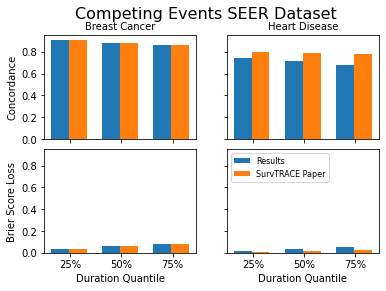

In [21]:
# PLOT COMPETING EVENT RESULTS - SEER DATA SET
ind = np.arange(3)
width=.35

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=.1, wspace=0.2)
plt.setp(axs, xticks=[0.2, 1.2, 2.2], xticklabels=['25%', '50%', '75%'])
plt.suptitle("Competing Events SEER Dataset", fontsize=16)

axs[0][0].bar(ind, met['seer'][0][0], width=width, label='Results')
axs[0][0].bar(ind+width, seerb_c_paper, width=width, label='SurvTRACE Paper')
axs[0][0].set_title('Breast Cancer', fontsize=10)
axs[0][0].set_ylabel('Concordance')

axs[0][1].bar(ind, met['seer'][0][1], width=width, label='Results')
axs[0][1].bar(ind+width, seerh_c_paper, width=width, label='SurvTRACE Paper')
axs[0][1].set_title('Heart Disease', fontsize=10)

axs[1][0].bar(ind, met['seer'][1][0], width=width, label='Results')
axs[1][0].bar(ind+width, seerb_b_paper, width=width, label='SurvTRACE Paper')
axs[1][0].set_ylabel('Brier Score Loss')
axs[1][0].set_xlabel('Duration Quantile')

axs[1][1].bar(ind, met['seer'][1][1], width=width, label='Results')
axs[1][1].bar(ind+width, seerh_b_paper, width=width, label='SurvTRACE Paper')
axs[1][1].set_xlabel('Duration Quantile')

l = plt.legend(loc="upper left", prop={'size': 8})


## Single Event Results (SUPPORT & Metabric Data Sets)

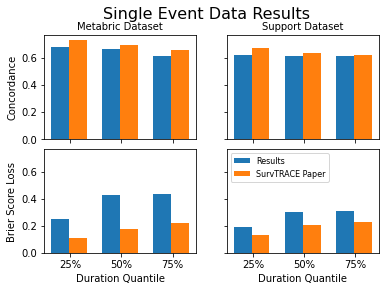

In [22]:
# PLOT SINGLE EVENT RESULTS - SUPPORT & METABRIC DATA SETS
meta_c_paper = [.728, .690, .655]
supp_c_paper = [.670, .633, .617]
meta_b_paper = [.110, .177, .219]
supp_b_paper = [.134, .206, .230]

ind = np.arange(3)
width=.35

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=.1, wspace=0.2)
plt.setp(axs, xticks=[0.2, 1.2, 2.2], xticklabels=['25%', '50%', '75%'])
plt.suptitle("Single Event Data Results", fontsize=16)

axs[0][0].bar(ind, met['metabric'][0][0], width=width, label='Results')
axs[0][0].bar(ind+width, meta_c_paper, width=width, label='SurvTRACE Paper')
axs[0][0].set_title('Metabric Dataset', fontsize=10)
axs[0][0].set_ylabel('Concordance')

axs[0][1].bar(ind, met['support'][0][0], width=width, label='Results')
axs[0][1].bar(ind+width, supp_c_paper, width=width, label='SurvTRACE Paper')
axs[0][1].set_title('Support Dataset', fontsize=10)

axs[1][0].bar(ind, met['metabric'][1][0], width=width, label='Results')
axs[1][0].bar(ind+width, meta_b_paper, width=width, label='SurvTRACE Paper')
axs[1][0].set_ylabel('Brier Score Loss')
axs[1][0].set_xlabel('Duration Quantile')


axs[1][1].bar(ind, met['support'][1][0], width=width, label='Results')
axs[1][1].bar(ind+width, supp_b_paper, width=width, label='SurvTRACE Paper')
axs[1][1].set_xlabel('Duration Quantile')

l = plt.legend(loc="upper left", prop={'size': 8})


## Comparison to Other Multi-Event Models

In [23]:
## Results Table for Other Method
dd = pd.DataFrame([met['seer'][0][0],met['seer'][0][1],
                    seerb_c_paper, seerh_c_paper,
                    deephitb, deephith,
                    dsmb, dsmh],
                  columns=pd.Index((['25%', '50%', '75%'])),
                  index=pd.MultiIndex.from_product([['Testing    |', 'SurvTRACE    |', 'DeepHit    |', 'DSM         |'],['Breast','Heart']]))# ,
dd.T.style.format(precision=4)
 

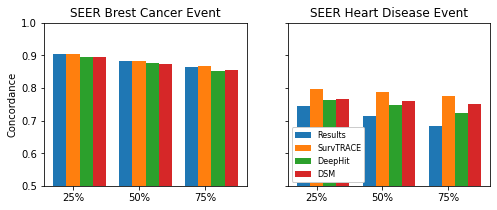

In [24]:
## Plot Comparison to Other Methods
ind = np.arange(3)
width=.2

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=.1, wspace=0.2)
fig.set_size_inches(8, 3)
plt.setp(axs, xticks=[0.2, 1.2, 2.2], xticklabels=['25%', '50%', '75%'])

axs[0].bar(ind, met['seer'][0][0], width=width, label='Results')
axs[0].bar(ind+width, seerb_c_paper, width=width, label='SurvTRACE')
axs[0].bar(ind+2*width, deephitb, width=width, label='DeepHit')
axs[0].bar(ind+3*width, dsmb, width=width, label='DSM')
axs[0].set_title('SEER Brest Cancer Event')
axs[0].set_ylabel('Concordance')
axs[0].set_ylim([.5, 1])

axs[1].bar(ind, met['seer'][0][1], width=width, label='Results')
axs[1].bar(ind+width, seerh_c_paper, width=width, label='SurvTRACE')
axs[1].bar(ind+width*2, deephith, width=width, label='DeepHit')
axs[1].bar(ind+width*3, dsmh, width=width, label='DSM')
axs[1].set_title('SEER Heart Disease Event')

l = plt.legend(loc="lower left", prop={'size': 8},
               facecolor="white", framealpha=1)


# Parameter Grid Testing

In [25]:
# GRID PARAMETER TESTING
run_grid = False
if run_grid:
    EPOCHS = 20
    BATCH_SIZE = 1280
    LR = 1e-3  #learning rate default= 1e-3
    WT_DECAY = 1e-4  #weight decay defalt le-4

    grid_data = pd.DataFrame()
    # #heads, embe_size, Intermediate_size, hidden_layers, 
    for heads in [2]:
        STConfig.num_attention_heads = heads
        for hid_size in [16]:
            STConfig.hidden_size = hid_size
            HIDDEN_SIZE = hid_size
            for num_hid_lay in [2]:
                STConfig.num_hidden_layers = num_hid_lay
                for im_size in [32]:
                    STConfig.intermediate_size = im_size
                    for hid_drop in [0,.1,.2]:
                        STConfig.hidden_dropout_prob = hid_drop
                        for lrate in [1e-2, 1e-3, 1e-4]:
                            LR = lrate
                            print('---')
                            print('EPOCHS=', EPOCHS, 'BATCH=', BATCH_SIZE, 'LR=', lrate, 'Drop=', hid_drop)
                            print('HID SIZE', hid_size, 'HID_LAYERS', num_hid_lay, "IM_SIZE", im_size)
                            train_loader = torch.utils.data.DataLoader(
                                CustomDataset(train_data), 
                                batch_size = BATCH_SIZE, 
                                shuffle=True)
                            val_loader = torch.utils.data.DataLoader(
                                CustomDataset(val_data), 
                                batch_size = BATCH_SIZE, 
                                shuffle=False)
              
                            model = ST_Model().to(DEVICE)
                            train_loss_list, val_loss_list = train(
                                model, 
                                train_loader, 
                                val_loader, 
                                weight_decay=WT_DECAY,
                                learning_rate=LR, 
                                n_epochs=EPOCHS, 
                                verbose=False)
                            Eval = Evaluator1(df_train)
                            Eval.eval(model, x_test, df_test, brier=True)
                            print(' ')
  
  